In [99]:

# Regressor com o propósito de apoiar os analistas de conceção de crédito  com uma sugestão de valor a ser aprovado
# Os métodos de limpeza são os mesmos utilizados no clusterizador
#Variáveis utilizadas.
#   faturamentoBruto,margemBruta,restricoes,intervaloFundacao
#Resultados do regresor para valores solicitados < 100000. Representa 74% das solicitaçoes de crédito
# Melhor regresor para este caso: Random Forest
# Regressor Random Forest. Mean Squared Error: 213,057,997.51. Mean absolute percentage error: 6.25. Mean Error 10,892.36


import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification


#Regression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate
from sklearn.metrics import median_absolute_error, mean_squared_error


# carrega o dataset
dataset = pd.read_csv('./solicitacoescredito.csv')

#print(dataset.head())

# periodoDemonstrativoEmMeses -> converte valores nulos ou 0 em 1
dataset['periodoDemonstrativoEmMeses'] = dataset['periodoDemonstrativoEmMeses'].replace(np.nan, 1)
dataset['periodoDemonstrativoEmMeses'] = dataset['periodoDemonstrativoEmMeses'].replace(0, 1)

# faturamentoBruto -> converte valores nulos em 0 
dataset['faturamentoBruto'] = dataset['faturamentoBruto'].replace(np.nan, 0)
dataset['faturamentoBruto'] = dataset['faturamentoBruto'] / dataset['periodoDemonstrativoEmMeses']
dataset['mergemBruta'] = dataset['margemBruta'] / dataset['periodoDemonstrativoEmMeses']
dataset.dropna(subset=['margemBruta'], inplace=True)
dataset=dataset.loc[dataset['valorAprovado']>0]
dataset=dataset.query('valorAprovado<=valorSolicitado')
dataset=dataset.loc[dataset['valorSolicitado']<100000  ]

definicaoRisco = dataset['definicaoRisco']                            # ######## ver tratamento (abaixo)

percentualRisco = dataset['percentualRisco']                          # ok
faturamentoBruto = dataset['faturamentoBruto']

margemBruta = dataset['margemBruta']                                    # ######## ver tratamento (abaixo)
intervaloFundacao = dataset['intervaloFundacao']                      # ######## ver tratamento (abaixo)
restricoes = dataset['restricoes']                                      # ######## ver tratamento (abaixo)
limiteEmpresaAnaliseCredito = dataset['limiteEmpresaAnaliseCredito']  # ######## ver tratamento (abaixo)
valorSolicitado = dataset['valorSolicitado']
valorAprovado = dataset['valorAprovado']


In [100]:
# monta o dataset que será trabalhado
df = pd.concat([
    faturamentoBruto,
    margemBruta,
    restricoes,
    intervaloFundacao,
], axis=1)


#Tratamento das features categóricas
df=pd.get_dummies(df,columns=['intervaloFundacao','restricoes',], prefix=['int_func','restricoes'])


In [101]:
X = df.values
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
y = valorAprovado.values

names = ["Nearest Neighbors", 
         "Nearest Neighbors 4",
         "Linear SVM", 
         "RBF SVM",
         "Decission Tree 5",
         "Decision Tree 7", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         "GAussian Process Regressor"

        ]

classifiers = [
    KNeighborsRegressor(3),
    KNeighborsRegressor(4),
    SVR(kernel="linear", C=0.025),
    SVR(C=1),
    DecisionTreeRegressor(max_depth=5),
    DecisionTreeRegressor(max_depth=20),
    RandomForestRegressor(max_depth=10, n_estimators=500),
    MLPRegressor(max_iter=1000,hidden_layer_sizes=(100,100,100,)),
    AdaBoostRegressor(n_estimators=100),
    GaussianProcessRegressor()
    ]
l=len(classifiers)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

list_scores=list()
list_std=list()
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = cross_validate(clf,X,y,n_jobs=2,verbose=0,cv=3,scoring =["neg_mean_squared_error","neg_mean_absolute_percentage_error","neg_mean_absolute_error"])

    print("Regressor {}. Mean Squared Error: {:,.2f}. Mean absolute percentage error: {:,.2f}. Mean Error {:,.2f}".
          format(name,-1*score['test_neg_mean_squared_error'].mean(),
                 -1*score['test_neg_mean_absolute_percentage_error'].mean(),-1*score['test_neg_mean_absolute_error'].mean()))


Regressor Nearest Neighbors. Mean Squared Error: 265,142,444.28. Mean absolute percentage error: 6.98. Mean Error 11,886.74
Regressor Nearest Neighbors 4. Mean Squared Error: 259,899,666.15. Mean absolute percentage error: 6.25. Mean Error 11,839.36
Regressor Linear SVM. Mean Squared Error: 405,840,783.04. Mean absolute percentage error: 5.42. Mean Error 15,003.42
Regressor RBF SVM. Mean Squared Error: 404,013,722.32. Mean absolute percentage error: 5.47. Mean Error 14,981.76
Regressor Decission Tree 5. Mean Squared Error: 233,118,114.41. Mean absolute percentage error: 6.34. Mean Error 11,509.74
Regressor Decision Tree 7. Mean Squared Error: 308,769,034.56. Mean absolute percentage error: 6.31. Mean Error 11,795.31
Regressor Random Forest. Mean Squared Error: 213,057,997.51. Mean absolute percentage error: 6.25. Mean Error 10,892.36
Regressor Neural Net. Mean Squared Error: 324,180,175.49. Mean absolute percentage error: 7.88. Mean Error 13,894.51
Regressor AdaBoost. Mean Squared Erro

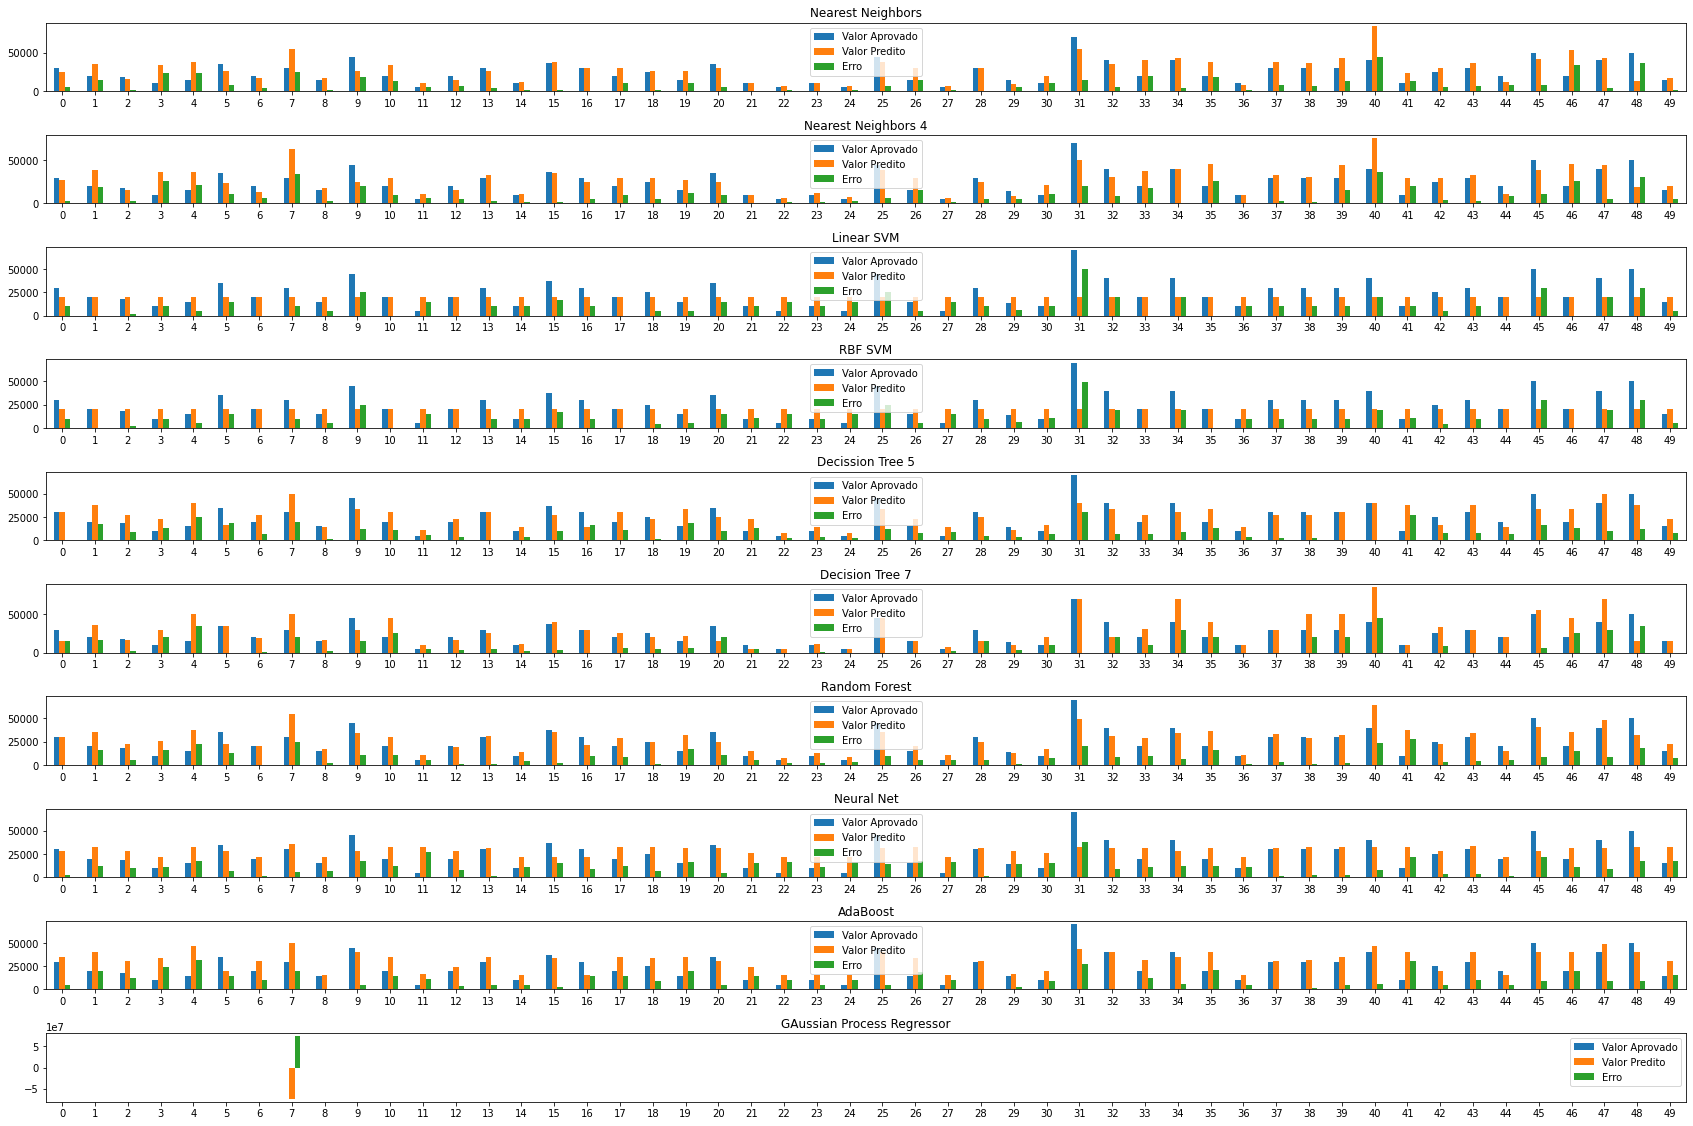

In [102]:

#Mostrar resultados 
#model=classifiers[4]

def cm_to_inch(value):
    return value/2.54

fig, axes = plt.subplots(nrows=len(classifiers), ncols=1, figsize=(cm_to_inch(60),cm_to_inch(40)))
for name, clf,ax in zip(names, classifiers,axes.flatten()):

    y_pred = clf.predict(X_test)
    predictions=y_pred #y_pred[:,0]
    predictions=predictions.astype(int)
    erros = np.absolute( y_test - predictions)
    finalresult = pd.DataFrame({
            "V Aprovado": y_test,
            "V Predito": predictions,
            "Erro" : erros
        })

    dfresult = pd.DataFrame({
        "Valor Aprovado": y_test,
        "Valor Predito": predictions, #y_pred[:,0]
        "Erro" : erros
        })
    ax.title.set_text(name)
    dfresult.head(50).plot.bar(rot=0,ax=ax,figsize=(cm_to_inch(60),cm_to_inch(40)))
plt.tight_layout()
plt.show()





Cálculo de crédito a ser aporovado
Variáveis utilizadas.
   faturamentoBruto,margemBruta,restricoes,intervaloFundacao
Resultados do regresor para valores solicitados < 100000





  
    
    


Random Forest


<AxesSubplot:>

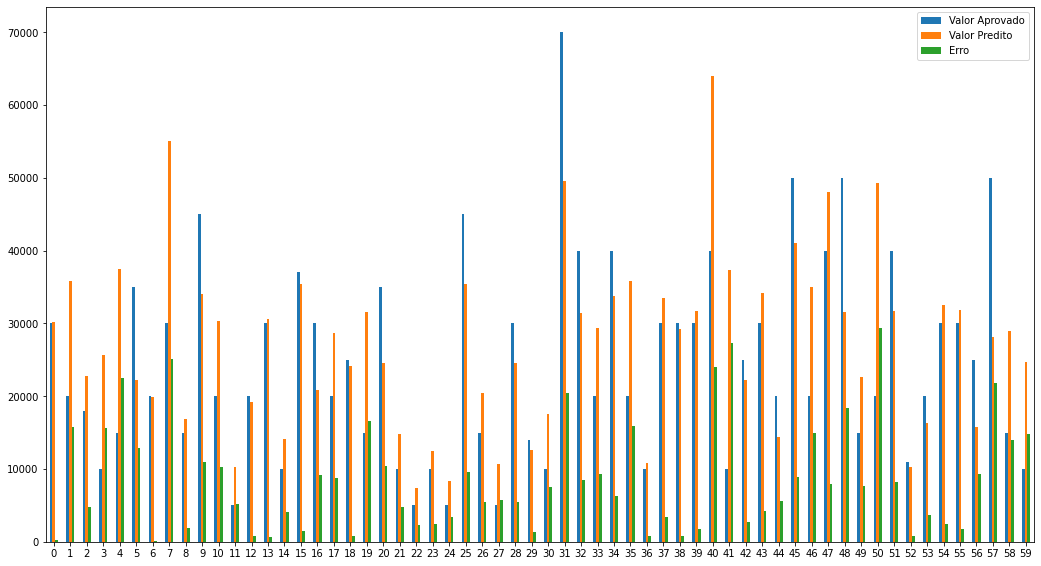

In [103]:
model=classifiers[6]
name=names[6]

y_pred = model.predict(X_test)
predictions=y_pred #y_pred[:,0]
predictions=predictions.astype(int)
erros = np.absolute( y_test - predictions)
finalresult = pd.DataFrame({
            "V Aprovado": y_test,
            "V Predito": predictions,
            "Erro" : erros
            })
dfresult = pd.DataFrame({
        "Valor Aprovado": y_test,
        "Valor Predito": predictions, #y_pred[:,0]
        "Erro" : erros
        })
print(name)
dfresult.head(60).plot.bar(rot=0,figsize=(cm_to_inch(45 ),cm_to_inch(25)))


In [104]:
dataset = pd.read_csv('./solicitacoescredito.csv')
dataset=dataset.loc[dataset['valorAprovado']>0]
dataset=dataset.loc[dataset['valorSolicitado']<100000  ]
dataset.info()
print(5192/(8960-1866))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5192 entries, 0 to 8960
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numero_solicitacao           5192 non-null   int64  
 1   razaoSocial                  5192 non-null   object 
 2   nomeFantasia                 5192 non-null   object 
 3   cnpjSemTraco                 5192 non-null   object 
 4   maiorAtraso                  5192 non-null   int64  
 5   margemBrutaAcumulada         5192 non-null   float64
 6   percentualProtestos          4438 non-null   float64
 7   primeiraCompra               5162 non-null   object 
 8   prazoMedioRecebimentoVendas  5192 non-null   int64  
 9   titulosEmAberto              5192 non-null   float64
 10  valorSolicitado              5192 non-null   float64
 11  status                       5192 non-null   object 
 12  definicaoRisco               5192 non-null   object 
 13  diferencaPercentua

In [105]:
dataset = pd.read_csv('./solicitacoescredito.csv')
dataset=dataset.loc[dataset['valorAprovado']==0]
#dataset=dataset.loc[dataset['valorSolicitado']>30000  ]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 1866 to 5608
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numero_solicitacao           4 non-null      int64  
 1   razaoSocial                  4 non-null      object 
 2   nomeFantasia                 4 non-null      object 
 3   cnpjSemTraco                 4 non-null      object 
 4   maiorAtraso                  4 non-null      int64  
 5   margemBrutaAcumulada         4 non-null      float64
 6   percentualProtestos          3 non-null      float64
 7   primeiraCompra               4 non-null      object 
 8   prazoMedioRecebimentoVendas  4 non-null      int64  
 9   titulosEmAberto              4 non-null      float64
 10  valorSolicitado              4 non-null      float64
 11  status                       4 non-null      object 
 12  definicaoRisco               4 non-null      object 
 13  diferencaPercentua

In [106]:
pd.read_csv('./solicitacoescredito.csv').query('valorAprovado<=valorSolicitado').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7522 entries, 0 to 8961
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numero_solicitacao           7522 non-null   int64  
 1   razaoSocial                  7522 non-null   object 
 2   nomeFantasia                 7522 non-null   object 
 3   cnpjSemTraco                 7522 non-null   object 
 4   maiorAtraso                  7522 non-null   int64  
 5   margemBrutaAcumulada         7522 non-null   float64
 6   percentualProtestos          6326 non-null   float64
 7   primeiraCompra               7477 non-null   object 
 8   prazoMedioRecebimentoVendas  7522 non-null   int64  
 9   titulosEmAberto              7522 non-null   float64
 10  valorSolicitado              7522 non-null   float64
 11  status                       7522 non-null   object 
 12  definicaoRisco               7522 non-null   object 
 13  diferencaPercentua